In [1]:
from Tools import *
from U_net import *

In [2]:
crop_size = (512, 512)
# crop_size = (420, 600)
train = GunsDataset(crop_size, 'train')
val = GunsDataset(crop_size, 'valid')
test = GunsDataset(crop_size, 'test')

read 624 examples
read 59 examples
read 30 examples


In [3]:
batch_size = 8
train_iter = torch.utils.data.DataLoader(train, batch_size, shuffle=True, num_workers=1)
val_iter = torch.utils.data.DataLoader(val, batch_size, shuffle=False, num_workers=1)
test_iter = torch.utils.data.DataLoader(test, batch_size, shuffle=False, num_workers=1)

In [4]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 512, 512])


In [5]:
net = create_unet()

C:\Users\roirt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [6]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)
    
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def binnary_IoU(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    intersection = float((y_hat.type(y.dtype) * y).sum())
    union = float((y_hat.type(y.dtype) + y).clamp(0, 1).sum())
    return intersection, union

In [7]:
num_epochs, lr, wd, device = 50, 0.003, 1e-3, torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
model = net.to(device)

for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    Acc_N = 0
    TestAcc = 0.0
    TestN = 0.0
    Union = 0.0
    Intersection = 0.0
    TestUnion = 0.0
    TestIntersection = 0.0
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        l = loss(model(X),y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        L += l.sum()
        N += l.numel()
        Acc += accuracy(model(X), y)
        IoU = binnary_IoU(model(X), y)
        Intersection += IoU[0]
        Union += IoU[1]
        Acc_N += y.numel()
    for X, y in val_iter:
        X, y = X.to(device), y.to(device)
        TestN += y.numel()
        TestAcc += accuracy(model(X), y)
        IoU = binnary_IoU(model(X), y)
        TestIntersection += IoU[0]
        TestUnion += IoU[1]
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/Acc_N):f}, train IoU  {(Intersection/Union):f}\
          , test accuracy {(TestAcc/TestN):f}, test IoU {(TestIntersection/TestUnion):f}')

epoch 1, loss 0.420222          , train accuracy  0.863855, train IoU  0.038923          , test accuracy 0.902182, test IoU 0.025546
epoch 2, loss 0.389943          , train accuracy  0.881518, train IoU  0.027744          , test accuracy 0.913886, test IoU 0.022914
epoch 3, loss 0.370432          , train accuracy  0.890010, train IoU  0.024073          , test accuracy 0.918027, test IoU 0.023188
epoch 4, loss 0.358461          , train accuracy  0.894150, train IoU  0.023108          , test accuracy 0.919575, test IoU 0.023523
epoch 5, loss 0.352001          , train accuracy  0.894284, train IoU  0.028387          , test accuracy 0.921865, test IoU 0.029209
epoch 6, loss 0.339221          , train accuracy  0.896373, train IoU  0.037177          , test accuracy 0.922987, test IoU 0.048587
epoch 7, loss 0.331958          , train accuracy  0.896659, train IoU  0.045569          , test accuracy 0.923163, test IoU 0.063781
epoch 8, loss 0.318491          , train accuracy  0.898781, train IoU

In [16]:
next_batch = next(iter(test_iter))
X, y = next_batch

In [20]:
torch.save(model.to('cpu').state_dict(), 'modelo.pt')

In [17]:
j=6
a=X[j].unsqueeze(0)
model=model.to('cpu')
pred = model(a).argmax(dim=1)

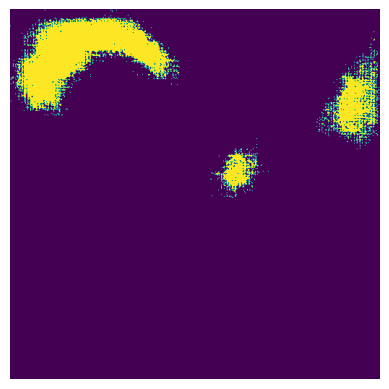

In [18]:
plt.imshow(pred.permute(1, 2, 0).numpy())
plt.axis('off')  # Opcional: desactiva los ejes
plt.show()

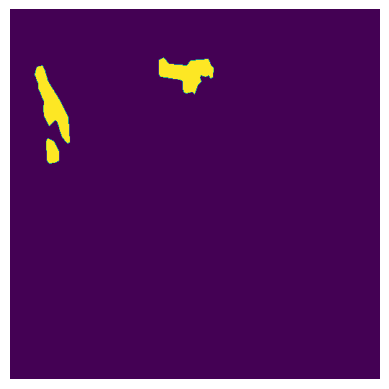

In [19]:
plt.imshow((y[j].unsqueeze(0).to('cpu')).permute(1, 2, 0).numpy())
plt.axis('off')  # Opcional: desactiva los ejes
plt.show()